# item特征优化

In [2]:
import sys
from pathlib import Path
import csv
import json
import threading
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from dotenv import load_dotenv
from google import genai
from IPython.display import display
from polars.exceptions import NoDataError
from tqdm.notebook import tqdm

In [ ]:
# Data directory
CATEGORY = "Movies_and_TV"
DATA_DIR = Path("/home/zihao/llm/llm4rec/data")

In [39]:
load_dotenv()

# API settings
MODEL = "gemini-2.5-flash-lite"
MAX_RETRIES: int = 5
RETRY_DELAY: float = 1.0  # Seconds
RATE_LIMIT_DELAY: float = 0.2  # Seconds between API calls
MAX_THREADS: int = 10

# Text processing settings
MAX_DESCRIPTION_LENGTH: int = 3000  # Truncate combined text before sending to API (combine field can be up to ~2700 chars)

## item数据加载

In [5]:
# 加载数据
df_hot = pl.read_parquet(DATA_DIR / "output" / f"{CATEGORY}_hot_items.parquet").drop(["average_rating", "rating_number"])
print(f"已加载 {len(df_hot):,} 条商品数据（hot），来源：{DATA_DIR / 'output' / f'{CATEGORY}_hot_items.parquet'}")

df_cold = pl.read_parquet(DATA_DIR / "output" / f"{CATEGORY}_cold_items.parquet").drop(["average_rating", "rating_number"])
print(f"已加载 {len(df_cold):,} 条商品数据（cold），来源：{DATA_DIR / 'output' / f'{CATEGORY}_cold_items.parquet'}")

# 合并数据
df = pl.concat([df_hot, df_cold])

print(f"合并完成，最终数据集共 {len(df):,} 行")

已加载 33,978 条商品数据（hot），来源：/home/zihao/llm/llm4rec/data/output/Movies_and_TV_hot_items.parquet
已加载 6,602 条商品数据（cold），来源：/home/zihao/llm/llm4rec/data/output/Movies_and_TV_cold_items.parquet
合并完成，最终数据集共 40,580 行


In [6]:
df

main_category,title,features,description,store,categories,details,parent_asin
str,str,str,str,str,str,str,str
"""Movies & TV""","""Norma Rae: 35th Anniversary""","""""","""A union organizer from up Nort…","""Sally Field (Actor), Beau Brid…","""Movies & TV > Featured Categor…","""{""Aspect Ratio"": ""2.40:1"", ""Is…","""B00HVTRDZ8"""
"""Movies & TV""","""Psych: The Musical [DVD]""","""""","""Shawn (James Roday) and Gus (D…","""James Roday (Actor), Dule Hill…","""Movies & TV > Musicals & Perfo…","""{""Genre"": ""Musicals & Performi…","""B00FMR66J0"""
"""Movies & TV""","""Red Sun""","""""","""Product Description NTSC/Regio…","""Charles Bronson (Actor), Toshi…","""Movies & TV > Genre for Featur…","""{""Genre"": ""Drama"", ""Format"": ""…","""B000ROAPTA"""
"""Movies & TV""","""HEE HAW: COLLECTOR'S EDITION""","""""","""The complete set includes 2 Bo…","""JOHNNY CASH (Actor) Format: DV…","""Movies & TV > Music Artists > …","""{""Genre"": ""Television"", ""Forma…","""B01H3KUHQQ"""
"""Movies & TV""","""Tracy Anderson: Method Express""","""""","""Fitness icon Tracy Anderson ha…","""Tracy Anderson (Actor) Rated: …","""Movies & TV > TV""","""{""Genre"": ""Fitness & Exercise""…","""B00SWZIZIO"""
…,…,…,…,…,…,…,…
"""Movies & TV""","""How the Grinch Stole Christmas…","""""","""VHS tape new in factory sealed…","""Jim Carrey (Actor), Taylor Mom…","""Movies & TV > Genre for Featur…","""{""Is Discontinued By Manufactu…","""B00005MP69"""
"""Movies & TV""","""The Terminator""","""""","""SINGLE LASER DISC - DIGITAL AU…","""""","""Movies & TV > Movies""","""{""Package Dimensions"": ""7.1 x …","""B000R5OGF8"""
"""Movies & TV""","""Secondhand Lions""","""""","""This comedic and touching fami…","""Michael Caine (Actor), Robert …","""Movies & TV > Genre for Featur…","""{""Aspect Ratio"": ""1.85:1"", ""Is…","""B000B5IOWA"""


In [7]:
df.group_by("main_category").len().sort("len", descending=True)
# 特征基本重复，重要性比较低

main_category,len
str,u32
"""Movies & TV""",33052
"""Prime Video""",6441
"""""",1068
"""Video Games""",6
"""Sports & Outdoors""",5
"""Digital Music""",3
"""Toys & Games""",2
"""All Electronics""",1
"""Amazon Home""",1


In [8]:
cols = ["title", "description", "categories", "details", "features", "store"]

df = df.with_columns(
    pl.struct(cols)
      .map_elements(
          lambda row: "\n".join(f"{k}:{v}" for k, v in row.items() if v is not None)
      )
      .alias("combine")
)
df.head(5)

main_category,title,features,description,store,categories,details,parent_asin,combine
str,str,str,str,str,str,str,str,str
"""Movies & TV""","""Norma Rae: 35th Anniversary""","""""","""A union organizer from up Nort…","""Sally Field (Actor), Beau Brid…","""Movies & TV > Featured Categor…","""{""Aspect Ratio"": ""2.40:1"", ""Is…","""B00HVTRDZ8""","""title:Norma Rae: 35th Annivers…"
"""Movies & TV""","""Psych: The Musical [DVD]""","""""","""Shawn (James Roday) and Gus (D…","""James Roday (Actor), Dule Hill…","""Movies & TV > Musicals & Perfo…","""{""Genre"": ""Musicals & Performi…","""B00FMR66J0""","""title:Psych: The Musical [DVD]…"
"""Movies & TV""","""Red Sun""","""""","""Product Description NTSC/Regio…","""Charles Bronson (Actor), Toshi…","""Movies & TV > Genre for Featur…","""{""Genre"": ""Drama"", ""Format"": ""…","""B000ROAPTA""","""title:Red Sun description:Prod…"
"""Movies & TV""","""HEE HAW: COLLECTOR'S EDITION""","""""","""The complete set includes 2 Bo…","""JOHNNY CASH (Actor) Format: DV…","""Movies & TV > Music Artists > …","""{""Genre"": ""Television"", ""Forma…","""B01H3KUHQQ""","""title:HEE HAW: COLLECTOR'S EDI…"
"""Movies & TV""","""Tracy Anderson: Method Express""","""""","""Fitness icon Tracy Anderson ha…","""Tracy Anderson (Actor) Rated: …","""Movies & TV > TV""","""{""Genre"": ""Fitness & Exercise""…","""B00SWZIZIO""","""title:Tracy Anderson: Method E…"


In [9]:
def analyze_text_length(
    df: pl.DataFrame,
    col: str,
) -> Dict:
    lengths = df[col].str.len_chars()

    return {
        "min_length": lengths.min(),
        "max_length": lengths.max(),
        "mean_length": float(lengths.mean()),
        "median_length": lengths.median(),
    }

def analyze_all_text_lengths(df: pl.DataFrame) -> Dict[str, Dict]:
    results = {}

    for col, dtype in df.schema.items():
        if dtype == pl.Utf8:
            results[col] = analyze_text_length(df, col)

    return results

length_stats = analyze_all_text_lengths(df)

print("Text Length Statistics:")
print(json.dumps(length_stats, indent=2, ensure_ascii=False, default=str))

Text Length Statistics:
{
  "main_category": {
    "min_length": 0,
    "max_length": 24,
    "mean_length": 10.711853129620502,
    "median_length": 11.0
  },
  "title": {
    "min_length": 1,
    "max_length": 52,
    "mean_length": 24.067570231641202,
    "median_length": 23.0
  },
  "features": {
    "min_length": 0,
    "max_length": 34,
    "mean_length": 4.428437654016757,
    "median_length": 0.0
  },
  "description": {
    "min_length": 1,
    "max_length": 1280,
    "mean_length": 477.7636274026614,
    "median_length": 438.0
  },
  "store": {
    "min_length": 0,
    "max_length": 156,
    "mean_length": 58.767767373090194,
    "median_length": 64.0
  },
  "categories": {
    "min_length": 4,
    "max_length": 118,
    "mean_length": 47.892262198127156,
    "median_length": 49.0
  },
  "details": {
    "min_length": 2,
    "max_length": 1079,
    "mean_length": 512.8540906850666,
    "median_length": 505.0
  },
  "parent_asin": {
    "min_length": 10,
    "max_length": 10,
 

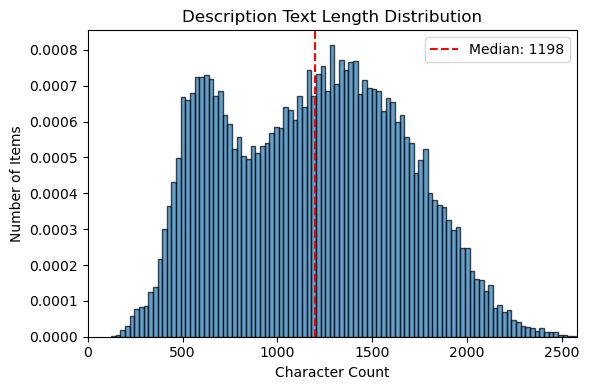

In [10]:
# Visualize text length distributions
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# Description lengths
desc_lengths = df["combine"].str.len_chars().to_list()
axes.hist(desc_lengths, bins=100, edgecolor="black", alpha=0.7, cumulative=False, density=True)
axes.axvline(np.median(desc_lengths), color="red", linestyle="--", label=f"Median: {np.median(desc_lengths):.0f}")
axes.set_xlabel("Character Count")
axes.set_ylabel("Number of Items")
axes.set_title("Description Text Length Distribution")
axes.legend()
axes.set_xlim(0, min(10000, max(desc_lengths)))

plt.tight_layout()
plt.show()

## 基于Gemini的数据提取

In [40]:
client = genai.Client()
test_response = client.models.generate_content(
    model=MODEL, contents="Say 'API connection successful' if you can read this.")
print(f"API Test: {test_response.text}")

API Test: API connection successful


In [51]:
PROMPT = """You are an expert at compressing Movies & TV content for embedding-based similarity search.

Task:
Extract and condense semantically important information into a concise, information-dense description. The output will be used for vector embeddings.

STRICT OUTPUT FORMAT:
You MUST output EXACTLY:
<clean_description>
[content]
</clean_description>

OUTPUT STRUCTURE:
Use the following labeled fields IN THIS ORDER.
Only include a field if the information is present or can be directly inferred from the content.

Title:
Category:
Identifiers:
Plot:
Language:

STYLE GUIDELINES:
- Use short, declarative sentences
- Use consistent, normalized phrasing
- Prefer weakly structured natural language with stable semantic anchors
- Do NOT invent facts (names, years, ratings, episode counts)
- You MAY infer high-level categories and genres from the content
- Avoid subjective or promotional language

FIELD RULES:

Title:
- Use the official title if present

Category:
- Infer 2–4 high-level categories from content, or from the Title only when it is a widely known work with a stable genre consensus; otherwise omit Category
- Use widely recognized, generic categories only
- Separate categories with commas
- Do NOT include store taxonomy, formats, or platforms

Identifiers:
- Include only factual identifiers if present:
  - Release year
  - Season number and episode count (format: "Season X, N episodes")
  - IMDb rating (format: "IMDb X.X")
  - TV rating or MPAA rating

Plot:
- Preserve key motivations, conflicts, and constraints
- Maintain cause-and-effect relationships
- Use 2–3 sentences
- Avoid character lists and actor names

Language:
- Include only if present

NORMALIZATION RULES:
- Do not repeat information across fields
- Remove store/platform metadata, IDs, pricing, reviews, and packaging details
- Fix truncated or broken sentences naturally when possible

EXAMPLE OUTPUT:
(The following is a correct example. Do NOT treat it as input.)

<clean_description>
Title: 2001: A Space Odyssey
Category: Science Fiction, Drama, Adventure
Identifiers: Unrated (Not Rated)
Plot: A mysterious monolith influences human evolution. A space mission to Jupiter encounters a sentient computer and leads to profound discoveries about humanity's place in the universe.
Language: English
</clean_description>

Now compress the following product information:
{description}

Your output:""".strip()

In [50]:
# CLEAN DESCRIPTION
def clean_description(prompt: str, description: str, model: str = MODEL) -> str:
    """
    Send a prompt and description to Gemini API for cleaning.

    Args:
        prompt: The cleaning instructions prompt
        description: The text description to clean
        model: The Gemini model to use (defaults to MODEL constant)

    Returns:
        Cleaned description text from Gemini
    """
    attempt = 0
    while attempt < MAX_RETRIES:
        try:
            # Format the full prompt with the description
            full_prompt = prompt.format(description=description)

            # Generate content using Gemini with suppressed output

            response = client.models.generate_content(model=model, contents=full_prompt)

            # Extract the cleaned text from response
            cleaned_text = f"{response.text.strip()}"

            # Extract content between tags if present
            if "<clean_description>" in cleaned_text and "</clean_description>" in cleaned_text:
                start = cleaned_text.find("<clean_description>") + len("<clean_description>")
                end = cleaned_text.find("</clean_description>")
                cleaned_text = cleaned_text[start:end].strip()
                return cleaned_text
            else:
                # If tags not found, increment attempt and retry
                attempt += 1
                if attempt < MAX_RETRIES:
                    print(f"Tags not found in response, retrying... (attempt {attempt}/{MAX_RETRIES})")
                    time.sleep(RETRY_DELAY)
                continue

        except Exception as e:
            attempt += 1
            if attempt < MAX_RETRIES:
                print(f"Error cleaning with Gemini: {e}, retrying... (attempt {attempt}/{MAX_RETRIES})")
                time.sleep(RETRY_DELAY)
            else:
                print(f"Failed after {MAX_RETRIES} attempts: {e}")

    # Return original description if all attempts fail
    print(f"🚨 Returning 'NA' after {MAX_RETRIES} failed attempts")
    return "NA"


# Test the function with a sample combined text
test_description = df['combine'][10]
cleaned = clean_description(PROMPT, test_description)
print(f"Original (length: {len(test_description)}): {test_description}")
print(f"Cleaned (length: {len(cleaned)}): {cleaned}")

Original (length: 801): title:2001 a Space Odyssey
description:Blu-ray DVD disc is good for US and Canada.
categories:Movies & TV > Featured Categories > Blu-ray
details:{"Aspect Ratio": "1.78:1", "Is Discontinued By Manufacturer": "No", "MPAA rating": "Unrated (Not Rated)", "Product Dimensions": "6.69 x 5.31 x 0.47 inches; 2.47 Ounces", "Media Format": "Blu-ray", "Release date": "December 16, 2008", "Dubbed": "Spanish, French, German, Italian", "Subtitles": "Dutch, English, Spanish, French, Italian, Portuguese, Chinese, Korean, Danish, Norwegian, Swedish, Finnish", "Language": "Italian (Dolby Digital-Plus 5.1), German (Dolby Digital-Plus 5.1), English (Dolby Digital-Plus 5.1), French (Dolby Digital-Plus 5.1), Spanish (Dolby Digital-Plus 5.1)", "Number of discs": "1"}
features:
store:Rated: Unrated Format: Blu-ray
Cleaned (length: 311): Title: 2001: A Space Odyssey
Category: Science Fiction, Drama, Adventure
Identifiers: Unrated (Not Rated)
Plot: A mysterious monolith influences human 

In [56]:
# Setup checkpoint file
checkpoint_file = DATA_DIR / "output" / f"{CATEGORY}_combine_clean.csv"

# Load existing processed ASINs if checkpoint exists
processed_asins = set()
if checkpoint_file.exists():
    try:
        existing_df = pl.read_csv(checkpoint_file)
        processed_asins = set(existing_df["parent_asin"])
        print(f"Found {len(processed_asins):,} already processed items in checkpoint file")
    except NoDataError as e:
        print(f"CSV is empty: {e}")
        processed_asins = set()
else:
    # Create new CSV with headers
    with open(checkpoint_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["parent_asin", "clean_combine"])
    print(f"Created new checkpoint file: {checkpoint_file}")

# Filter to only unprocessed items
items_to_process = df.filter(~pl.col("parent_asin").is_in(processed_asins))
print(f"Items to process: {len(items_to_process):,} out of {len(df):,} total items")

# Thread-safe CSV writing lock
csv_lock = threading.Lock()


def process_single_item(item_data):
    """Process a single item and save to CSV."""
    asin, description = item_data

    try:
        # Truncate description if too long
        if len(description) > MAX_DESCRIPTION_LENGTH:
            description = description[:MAX_DESCRIPTION_LENGTH]

        # Clean the description
        cleaned = clean_description(PROMPT, description)

        # Skip writing if result is NA
        if cleaned == "NA":
            return asin, cleaned, False

        # Write immediately to CSV with lock
        with csv_lock:
            with open(checkpoint_file, "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([asin, cleaned])

        # Rate limiting
        time.sleep(RATE_LIMIT_DELAY)

        return asin, cleaned, True

    except Exception as e:
        print(f"Failed to process {asin}: {e}")
        return asin, description, False


# Prepare items for processing (using combined text)
items = [(row["parent_asin"], row["combine"]) for row in items_to_process.iter_rows(named=True)]

if len(items) > 0:
    print(f"Starting parallel processing with {10} workers...")

    # Process with ThreadPoolExecutor
    successful = 0
    failed = 0

    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        # Submit all tasks
        futures = {executor.submit(process_single_item, item): item for item in items}

        # Process completions with progress bar
        with tqdm(total=len(futures), desc="Processing items") as pbar:
            for future in as_completed(futures):
                try:
                    asin, result, success = future.result()
                    if success:
                        successful += 1
                    else:
                        failed += 1
                    pbar.update(1)
                    pbar.set_postfix({"success": successful, "failed": failed})

                except Exception as e:
                    failed += 1
                    pbar.update(1)
                    pbar.set_postfix({"success": successful, "failed": failed})
                    print(f"Future failed: {e}")

    print(f"Processing complete! Successful: {successful:,}, Failed: {failed:,}")

else:
    print("No items to process - all items already in checkpoint file!")

Found 40,577 already processed items in checkpoint file
Items to process: 3 out of 40,580 total items
Starting parallel processing with 10 workers...


Processing items:   0%|          | 0/3 [00:00<?, ?it/s]

Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 1/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 1/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 2/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 1/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 2/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 3/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 2/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 3/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 4/5)
Error cleaning with Gemini: 'NoneType' object has no attribute 'strip', retrying... (attempt 4/5)
Error cleaning with 

In [64]:
cleaned_df = pl.read_csv(checkpoint_file)
print(f"Loaded {len(cleaned_df):,} cleaned descriptions from {checkpoint_file}")

# Display sample of cleaned data
print("Sample of cleaned descriptions:")
display(cleaned_df.head(3))

Loaded 40,580 cleaned descriptions from /home/zihao/llm/llm4rec/data/output/Movies_and_TV_combine_clean.csv
Sample of cleaned descriptions:


parent_asin,clean_combine
str,str
"""B00FMR66J0""","""Title: Psych: The Musical Cate…"
"""B01H3KUHQQ""","""Title: HEE HAW: COLLECTOR'S ED…"
"""B001KY34FS""","""Title: Hollywood Canteen Categ…"


In [65]:
# 有一些生成没成功的，检查哪些没生成出来

# 找出哪些 parent_asin 在 cleaned_df 中不存在（即没生成出来）
processed_asins = set(cleaned_df['parent_asin'].to_list())
all_asins = set(df['parent_asin'].to_list())

not_generated_asins = all_asins - processed_asins

print(f"总共缺失生成的条数: {len(not_generated_asins)}")

missing_df = df.filter(pl.col('parent_asin').is_in(not_generated_asins))

for row in missing_df[['parent_asin', 'combine']].iter_rows(named=True):
    print(f"ASIN: {row['parent_asin']}\ncombine: {row['combine']}\n{'-'*40}")

总共缺失生成的条数: 0


In [63]:
# 用一个字典，显式地添加缺失生成项，键为 parent_asin，值为要补充的 clean_combine

# 示例：请在此根据缺失项填写
manual_entries_dict = {
    "B00AY6PK5A": "Title: Female Teacher: In Front Of The Students\nCategory: Drama, Thriller, Crime\nIdentifiers: 2013, X\nPlot: A new female teacher begins work at an isolated high school where she becomes the target of sexual violence and intimidation. An assault in the school locker room leaves behind a cryptic clue, drawing suspicion toward her students. As further abuse and retaliation occur, she confronts the source of the attacks and her own psychological and sexual turmoil.\nLanguage: Japanese (English subtitles)",
    "B074XL35M8": "Title: The Track\nCategory: Drama\nIdentifiers: 2017, IMDb 6.3, 16+\nPlot: A vulnerable teenage girl living on the margins crosses paths with an adult woman struggling with personal and financial hardship. Their encounter develops into a surrogate mother-daughter relationship that offers emotional support and protection. The bond becomes a shared path toward survival and stability.\nLanguage: English",
    "B000063K1Q": "Title: The Image\nCategory: Drama, Erotic\nIdentifiers: 2002, Unrated (Not Rated)\nPlot: A young woman enters a psychologically intense relationship with an older woman defined by power, control, and sexual experimentation. Their bond explores sadomasochistic desire and emotional dependency. The relationship exposes shifting dominance and personal boundaries.\nLanguage: English"
}

added_count = 0
with csv_lock:
    with open(checkpoint_file, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        for asin, cleaned in manual_entries_dict.items():
            writer.writerow([asin, cleaned])
            added_count += 1

print(f"已补充 {added_count} 条手动数据")

已补充 3 条手动数据


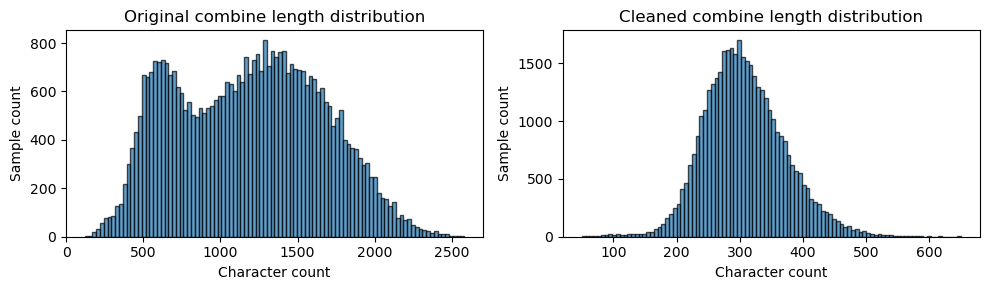

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Original df['combine'] length distribution
axes[0].hist(df['combine'].str.len_chars(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title("Original combine length distribution")
axes[0].set_xlabel("Character count")
axes[0].set_ylabel("Sample count")

# cleaned_df['clean_combine'] length distribution
axes[1].hist(cleaned_df['clean_combine'].str.len_chars(), bins=100, edgecolor='black', alpha=0.7)
axes[1].set_title("Cleaned combine length distribution")
axes[1].set_xlabel("Character count")
axes[1].set_ylabel("Sample count")

plt.tight_layout()
plt.show()